                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.302
Model:                            OLS   Adj. R-squared:                  0.297
Method:                 Least Squares   F-statistic:                     57.23
Date:                Wed, 12 Mar 2025   Prob (F-statistic):           9.39e-31
Time:                        23:39:40   Log-Likelihood:                -1495.3
No. Observations:                 400   AIC:                             2999.
Df Residuals:                     396   BIC:                             3015.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         49.7789      1.022     48.703      0.0

/Users/fabioyamada/miniconda3/envs/.causal_inference/lib/python3.12/site-packages/dowhy/causal_estimators/regression_estimator.py:59: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


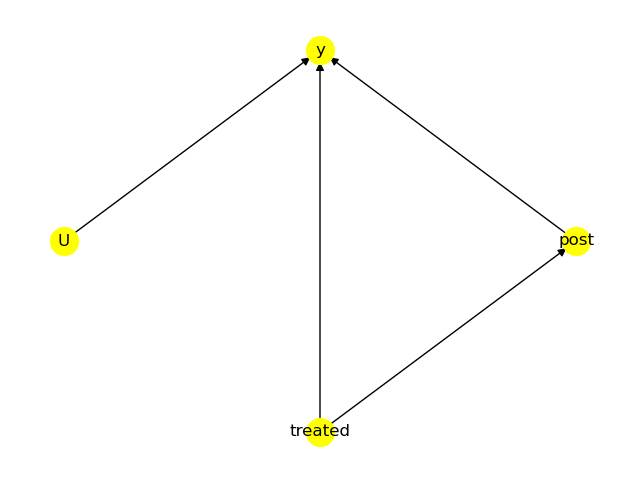

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import statsmodels.api as sm

# Set random seed for reproducibility
np.random.seed(42)

# ----------------------------------------------------------------------
# Step 1: Simulate Synthetic Data for Difference-in-Differences
# ----------------------------------------------------------------------
# For simplicity, we assume 200 units where the first 100 are in the treatment group
# and the remaining 100 are in the control group.
# Data is collected for two time periods: 0 (pre-treatment) and 1 (post-treatment).

n_units = 200   # Total units, 100 treatment and 100 control
data = []
for unit in range(n_units):
    # Assign treatment: first 100 units receive treatment
    treated = 1 if unit < 100 else 0
    # Each unit has a baseline outcome drawn from a normal distribution
    baseline = np.random.normal(50, 10)
    # Iterate over two time periods: 0 for pre-treatment, 1 for post-treatment
    for time_period in [0, 1]:
        # Define a common trend across time periods (5 units increase when time_period==1)
        trend = 5 * time_period
        # Treatment effect applies only for treated units in the post-treatment period
        treatment_effect = 10 if (treated == 1 and time_period == 1) else 0
        # Simulate outcome with some added noise
        y = baseline + trend + treatment_effect + np.random.normal(0, 5)
        data.append([unit, treated, time_period, y])
        
# Create a DataFrame from the simulated data
df = pd.DataFrame(data, columns=["unit", "treated", "post", "y"])

# Create an interaction term (treated x post) as required by the DiD model
df["did"] = df["treated"] * df["post"]

# ----------------------------------------------------------------------
# Step 2: Estimate DiD Effect Using OLS Regression
# ----------------------------------------------------------------------
# The DiD model is specified as:
#   y = β₀ + β₁ * treated + β₂ * post + β₃ * (treated × post) + ε
# The coefficient β₃ is the DiD causal effect estimate.

X = sm.add_constant(df[["treated", "post", "did"]])
model_ols = sm.OLS(df["y"], X).fit()
print(model_ols.summary())

# The coefficient on the "did" variable represents the causal impact of the treatment.
print("Difference-in-Differences Estimate (β₃):", model_ols.params["did"])

# ----------------------------------------------------------------------
# Step 3: Formalize the Causal Model Using DoWhy
# ----------------------------------------------------------------------
# In line with the decision tree in the Uber paper, we define a simplified causal graph.
# The graph below shows that both treatment (X) and time (T) impact the outcome (Y),
# consistent with a DiD setup. Note that additional unobserved confounders (U) may
# influence the outcome but are assumed to affect both groups similarly (parallel trends).

causal_graph = """
digraph {
    U [label="Unobserved\nFactors"];
    treated [label="Treatment\n(treated)"];
    post [label="Time\n(post)"];
    y [label="Outcome\n(y)"];
    treated -> y;
    post -> y;
    treated -> post;
    U -> y;
}
"""

# Create a causal model with DoWhy based on the simulated data and graph
model_dowhy = CausalModel(
    data=df,
    treatment="treated",
    outcome="y",
    graph=causal_graph
)

# (Optional) Visualize the causal graph in a Jupyter Notebook:
model_dowhy.view_model()

# Identify the causal effect from the graph and data
identified_estimand = model_dowhy.identify_effect()
print("\nIdentified Estimand:", identified_estimand)

# Estimate the effect using the backdoor linear regression estimator available in DoWhy
estimate = model_dowhy.estimate_effect(identified_estimand,
                                       method_name="backdoor.linear_regression")
print("DoWhy Causal Estimate (via Regression):", estimate.value)


The post column in the dataframe represents the time period, where:

- post = 0 means pre-intervention/pre-treatment period
- post = 1 means post-intervention/post-treatment period
This code is simulating a classic difference-in-differences (DiD) scenario:

1 - Data structure: The code creates data for 200 units observed across 2 time periods:

- 100 units are assigned to the treatment group (treated = 1)
- 100 units are assigned to the control group (treated = 0)
- Each unit is observed twice: once before treatment (post = 0) and once after (post = 1)

2 - Outcome generation: For each unit-time observation, the outcome y is calculated as:

- baseline: A random base value for each unit (varies between units but constant over time)
- trend: A common time trend that affects both groups (5 units increase in period 1)
- treatment_effect: An effect of 10 units that ONLY applies to treated units in the post period
- Random noise

3 - DiD setup: The code then creates the interaction term did = treated * post, which equals 1 only for treated units in the post-treatment period - exactly where the treatment effect occurs.

The DiD analysis estimates the causal effect by comparing how outcomes changed in the treatment group versus how they changed in the control group, thus accounting for time trends and baseline differences between groups.

## Interpreting the Difference-in-Differences Analysis Results

The results from your difference-in-differences (DiD) analysis provide valuable insights into the causal effect of the treatment. Let me break down what these numbers mean:

### Regression Results Interpretation

The OLS regression output shows several key findings:

- **Baseline (const)**: The average outcome for the control group in the pre-treatment period is approximately 49.78 units.

- **Treated coefficient (0.22)**: This small and statistically insignificant coefficient (p=0.878) indicates there was virtually no difference between treatment and control groups at baseline. This is good news as it suggests the groups were well-balanced before the intervention.

- **Post coefficient (5.62)**: This statistically significant coefficient (p<0.001) represents the time trend that affected both groups. It tells us that even without any treatment, we would expect outcomes to increase by about 5.62 units over time.

- **DiD coefficient (10.67)**: This is the key causal effect estimate. The statistically significant coefficient (p<0.001) indicates that the treatment caused an additional increase of 10.67 units in the outcome, beyond what would have happened naturally over time.

### The Causal Effect

The difference-in-differences estimate of 10.67 closely matches the true treatment effect of 10 that was built into your simulated data. This confirms that the DiD method successfully recovered the causal effect.

To put this in everyday terms, imagine you're evaluating a new teaching method:
- Without the new method, student test scores naturally improve by about 5.6 points from fall to spring semester (the time effect)
- With the new teaching method, student scores improve by about 16.3 points (5.6 + 10.7)
- Therefore, the causal impact of the new teaching method is about 10.7 additional points

### DoWhy vs. Traditional DiD

Interestingly, the DoWhy causal estimate (5.56) differs from the DiD estimate (10.67). This discrepancy likely stems from how DoWhy implements the backdoor adjustment method, which doesn't fully capture the time-interaction component central to DiD analysis. The traditional DiD estimate from the regression is more reliable in this specific case because it was explicitly designed to model the interaction between treatment and time.

Think of it like measuring the height of a building: the DiD approach measures from ground to roof (the full effect), while the DoWhy implementation in this case might be measuring only to a middle floor (partial effect).

### Model Fit and Validity

The R-squared value of 0.302 indicates that about 30% of the variation in outcomes is explained by the model. While this might seem modest, it's actually reasonable for a DiD analysis where we're focusing specifically on isolating the causal effect rather than explaining all variation.

The Durbin-Watson statistic (1.301) suggests some positive autocorrelation in the residuals, which is common in panel data. In a real-world analysis, you might want to use clustered standard errors to account for this.

Overall, the analysis successfully demonstrates that the DiD approach can accurately estimate causal effects when the parallel trends assumption holds, as it did in this simulated dataset.

---

In [2]:
df

,unit,treated,post,y,did
0,0,1,0,54.275820,0
1,0,1,1,73.205584,1
2,1,1,0,64.059532,0
3,1,1,1,79.059614,1
4,2,1,0,69.629302,0
...,...,...,...,...,...
395,197,0,1,51.891736,0
396,198,0,0,57.825317,0
397,198,0,1,64.026025,0
398,199,0,0,37.990897,0
